<a href="https://colab.research.google.com/github/mtamar/linear_glens/blob/main/gigalens_linefit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gigalens

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 27.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 10.7 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [1]:
!pip install corner

In [2]:
import matplotlib as mpl
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
from corner import corner
from tensorflow_probability import (
    distributions as tfd,
    bijectors as tfb,
    experimental as tfe,
)

"""from gigalens.tf.inference import ModellingSequence
from gigalens.tf.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.tf.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.tf.profiles.light import sersic
from gigalens.tf.profiles.mass import epl, shear"""

sns.set_style("whitegrid")
tfd = tfp.distributions

In [180]:
line_prior = tfd.JointDistributionNamed(
                  dict(
                      slope=tfd.Uniform(-10,10),
                      y_intercept=tfd.Uniform(-10,10),
                  )
              )


In [181]:
line_prior.sample(2)

{'y_intercept': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.8734932, 3.0455732], dtype=float32)>,
 'slope': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([3.617239 , 2.6347046], dtype=float32)>}

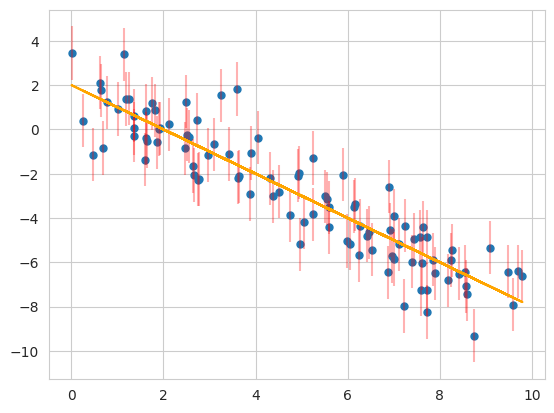

In [212]:
import random

# define truth parameters and noisy data

m = -1.0
b = 2.0
err = 1.2

truth = [{'slope': m, 'y_intercept': b}]

num_points = 100

x_observed = []
for i in range(num_points):
  x = random.uniform(0,10)
  x_observed.append(x)

x_observed = tf.cast(tf.constant(x_observed),tf.float32)
m = tf.cast(tf.constant([m]),tf.float32)
b = tf.cast(tf.constant([b]),tf.float32)

@tf.function
def line_model(x,params):
  m,b = params
  mx = tf.tensordot(m,x,axes=0)
  b_ = b[:,None]
  y = mx + b_
  return y

def line_noisy(x,params):
  m,b = params
  return line_model(x,(m,b)) + np.random.normal(loc=0.0,scale = np.sqrt(err), size = len(x))

y_observed = line_noisy(x_observed, (m,b))
y_observed = np.array(y_observed).flatten()
y_observed = tf.cast(tf.constant(y_observed),tf.float32)

# plot data points and truth line

plt.plot(x_observed, y_observed, '.', ms = 10)

plt.errorbar(x_observed, y_observed, yerr = err, marker = 's', fmt = 'None', ecolor = 'red', alpha = 0.3)
plt.plot(x_observed, tf.reshape(line_model(x_observed, (m,b)),(num_points)), color = 'orange')
plt.show()



In [356]:
from tqdm.auto import trange, tqdm

class ModellingSequence():
    def __init__(self, x_observed, y_observed):
        self.x_observed = x_observed
        self.y_observed = y_observed

    @tf.function
    def log_prob(self, x_observed, y_observed, m, b):
        # reshaping to match reinterpreted_ batch_ndims
        y_model = tf.reshape(line_model(x_observed, (m,b)), (num_points,-1))
        y_model = tf.reshape(y_model,(len(m),num_points))
        errs = tf.constant(err, shape=(len(m),num_points))

        log_like = tfd.Independent(tfd.Normal(y_model, errs), reinterpreted_batch_ndims=None).log_prob(y_observed)
        log_prior = line_prior.log_prob(dict(slope=m,y_intercept=b))

        return log_like + log_prior, tf.reduce_mean((y_observed - line_model(x_observed,(m,b)))**2/errs, axis = 1)


    def MAP(self, optimizer, start=None, n_samples=500, num_steps=350, seed=0):
        tf.random.set_seed(seed)
        start = line_prior.sample(n_samples)
        ms = start['slope']
        bs = start['y_intercept']
        ms_train = tf.Variable(ms, trainable = True)
        bs_train = tf.Variable(bs, trainable = True)

        @tf.function
        def train_step():
            with tf.GradientTape() as tape:
                log_probability, square_err = self.log_prob(self.x_observed, self.y_observed, ms_train, bs_train)
                agg_loss = tf.reduce_mean(-log_probability / len(x_observed))
            gradients = tape.gradient(agg_loss, [ms_train,bs_train])
            optimizer.apply_gradients(zip(gradients, [ms_train,bs_train]))

            return log_probability, square_err

        # get chi^2 and log probabilities for each step
        square_errs = []
        log_probs = []

        with trange(num_steps) as pbar:
            for _ in pbar:
                lp, square_err = train_step()
                square_errs.append(square_err)
                log_probs.append(lp)
                pbar.set_description(f"Chi Squared: {(np.nanmin(square_err)):.8f}")

        return ms_train, bs_train, log_probs, square_errs

    @tf.function
    def log_prob_SVI(self, x_observed, y_observed, params):
        m = params[:,0]
        b = params[:,1]

        y_model = tf.reshape(line_model(x_observed, (m,b)), (num_points,-1))
        y_model = tf.reshape(y_model,(len(m),num_points))
        errs = tf.constant(err, shape=(len(m),num_points))

        log_like = tfd.Independent(tfd.Normal(y_model, errs), reinterpreted_batch_ndims=None).log_prob(y_observed)
        log_prior = line_prior.log_prob(dict(slope=m,y_intercept=b))

        return tf.squeeze(log_like + log_prior)

    def SVI(self, optimizer, start, n_vi=250, init_scales=1e-3, num_steps=500, seed=2):
        tf.random.set_seed(seed)

        start = tf.squeeze(start)
        scale = (
          np.ones(len(start)).astype(np.float32) * init_scales
          if np.size(init_scales) == 1
          else init_scales
        )
        q_z = tfd.MultivariateNormalTriL(
          loc=tf.Variable(start),
          scale_tril=tfp.util.TransformedVariable(
              np.diag(scale),
              tfp.bijectors.FillScaleTriL(diag_bijector=tfb.Exp(), diag_shift=1e-6),
              name="stddev",
          ),
        )

        losses = tfp.vi.fit_surrogate_posterior(
          lambda z: self.log_prob_SVI(self.x_observed, self.y_observed, z),
          surrogate_posterior=q_z,
          sample_size=n_vi,
          optimizer=optimizer,
          num_steps=num_steps,

        )

        return q_z, losses

    def HMC(
          self,
          q_z,
          init_eps=0.3,
          init_l=3,
          n_hmc=50,
          num_burnin_steps=250,
          num_results=750,
          max_leapfrog_steps=30,
          seed=3,
          ):

      def tqdm_progress_bar_fn(num_steps):
          return iter(tqdm(range(num_steps), desc="", leave=True))

      tf.random.set_seed(seed)

      mc_start = q_z.sample(n_hmc)
      cov_estimate = q_z.covariance()

      momentum_distribution = (
          tfe.distributions.MultivariateNormalPrecisionFactorLinearOperator(
              precision_factor=tf.linalg.LinearOperatorLowerTriangular(
                  tf.linalg.cholesky(cov_estimate),
              ),
              precision=tf.linalg.LinearOperatorFullMatrix(cov_estimate),
          )
      )

      @tf.function
      def run_chain():
          num_adaptation_steps = int(num_burnin_steps * 0.8)
          start = tf.identity(mc_start)

          mc_kernel = tfe.mcmc.PreconditionedHamiltonianMonteCarlo(
              target_log_prob_fn=lambda z: self.log_prob_SVI(self.x_observed, self.y_observed, z),
              momentum_distribution=momentum_distribution,
              step_size=init_eps,
              num_leapfrog_steps=init_l,
          )

          mc_kernel = tfe.mcmc.GradientBasedTrajectoryLengthAdaptation(
              mc_kernel,
              num_adaptation_steps=num_adaptation_steps,
              max_leapfrog_steps=max_leapfrog_steps,
          )
          mc_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
              inner_kernel=mc_kernel, num_adaptation_steps=num_adaptation_steps
          )

          pbar = tfe.mcmc.ProgressBarReducer(
              num_results + num_burnin_steps - 1, progress_bar_fn=tqdm_progress_bar_fn
          )
          mc_kernel = tfe.mcmc.WithReductions(mc_kernel, pbar)

          return tfp.mcmc.sample_chain(
              num_results=num_results,
              num_burnin_steps=num_burnin_steps,
              current_state=start,
              kernel=mc_kernel,
              seed=seed,
          )

      return run_chain()




In [357]:
fitter = ModellingSequence(x_observed, y_observed)

In [358]:
# fitting MAP

schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(3e0, 500, 1e0)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
MAP = fitter.MAP(optimizer=optimizer, n_samples=500, num_steps=300, seed=0)

  0%|          | 0/300 [00:00<?, ?it/s]

In [360]:
# get best MAP results
ms_train, bs_train, log_probs, square_errs = MAP
lps = fitter.log_prob(x_observed, y_observed, ms_train, bs_train)[0]
best_idx = tf.argmax(lps).numpy()
MAP_m = ms_train[best_idx].numpy()
MAP_b = bs_train[best_idx].numpy()

best = tf.constant([MAP_m, MAP_b])
best

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.9985625,  1.9315448], dtype=float32)>

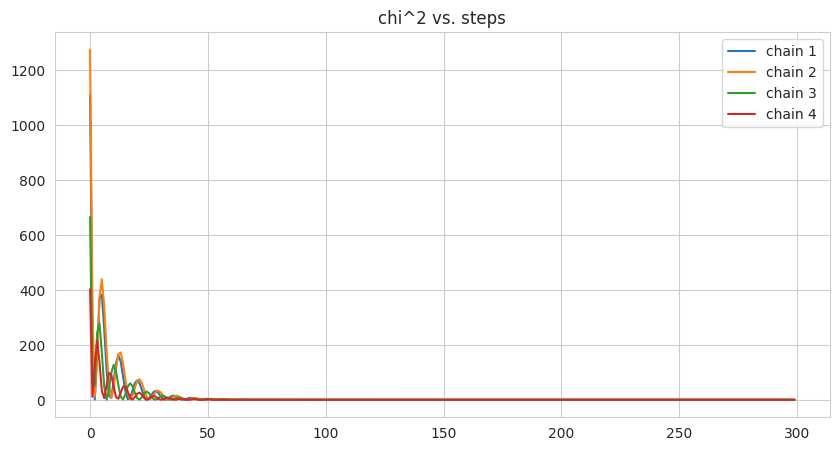

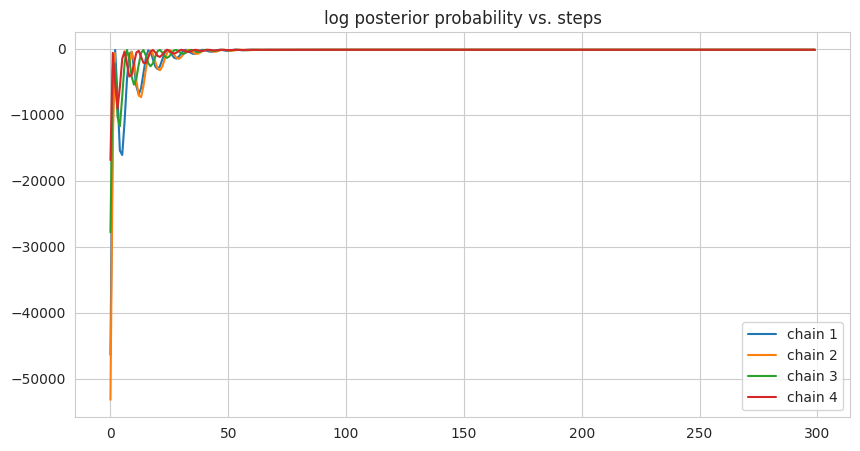

In [361]:
# chi^2 plot
chi2s = np.array(square_errs)
chain = chi2s[:,0:4]

plt.figure(figsize=(10, 5))
plt.plot(chain, label=['chain 1','chain 2','chain 3','chain 4']);
plt.title('chi^2 vs. steps')
plt.legend()

# posterior probability plot
log_probs = np.array(log_probs)
chain = log_probs[:,0:4]

plt.figure(figsize=(10, 5))
plt.plot(chain, label=['chain 1','chain 2','chain 3','chain 4']);
plt.title('log posterior probability vs. steps')
plt.legend()


In [362]:
# fit SVI
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(0.0, 500, 4e-3, 2)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
q_z, losses = fitter.SVI(optimizer=optimizer, start=best, n_vi=300, num_steps=1000)

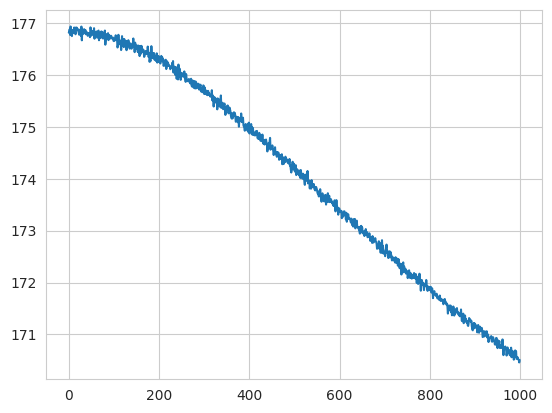

In [297]:
plt.plot(losses)

In [298]:
q_z.sample(10)

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[-0.9875934 ,  1.8301908 ],
       [-0.964518  ,  1.7418643 ],
       [-0.998293  ,  1.9392205 ],
       [-0.9758576 ,  1.8406459 ],
       [-1.0015732 ,  1.9488132 ],
       [-1.00714   ,  1.9782206 ],
       [-0.9922223 ,  1.8913372 ],
       [-1.0300678 ,  2.0767875 ],
       [-0.9869888 ,  1.9016609 ],
       [-0.98542094,  1.9077572 ]], dtype=float32)>

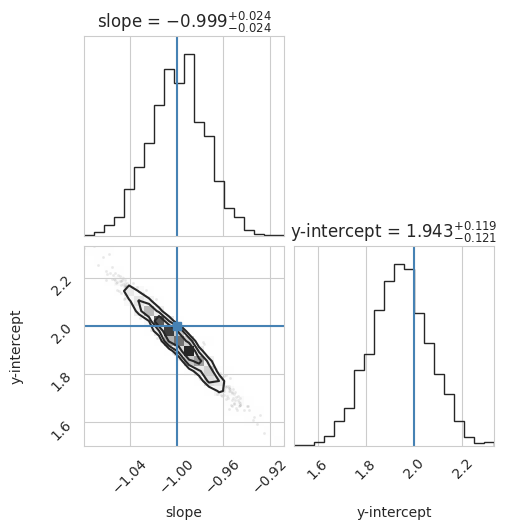

In [363]:
# make corner plot for SVI step
get_samples = lambda x:tf.convert_to_tensor([
    x[0]['slope'],
    x[0]['y_intercept']
])

physical_samples = q_z.sample(1000).numpy().reshape(1,1000,2)
markers = get_samples(truth)
corner(physical_samples, truths = markers, show_titles=True, title_fmt='.3f', labels = [r'slope', r'y-intercept']);

In [352]:
samples, sample_stats = fitter.HMC(q_z, n_hmc=50, init_eps=0.3, init_l=3, max_leapfrog_steps=300,
                                   num_burnin_steps=250, num_results=750)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


  0%|          | 0/999 [00:00<?, ?it/s]

Text(0.5, 1.0, 'slope histogram')

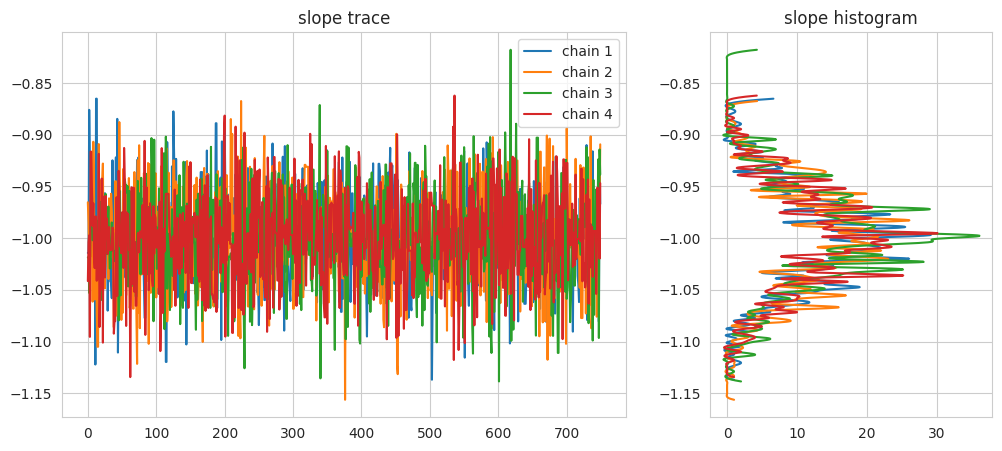

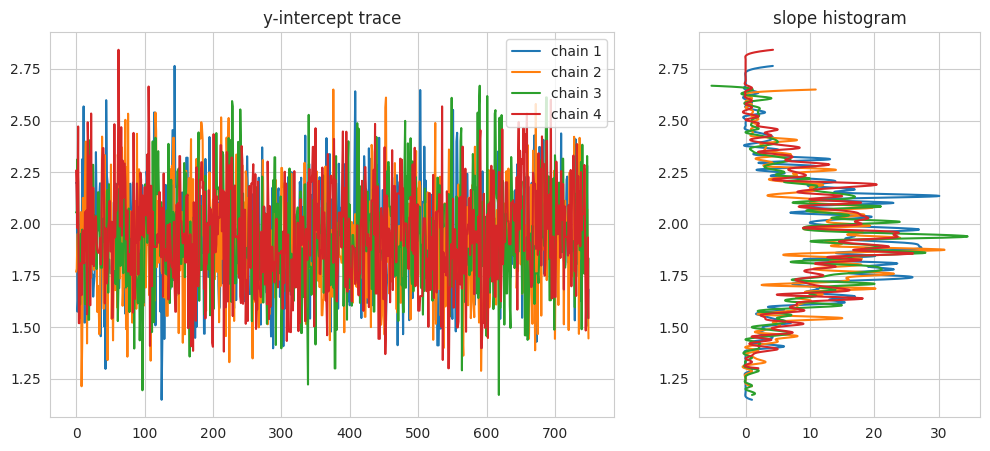

In [425]:
# plot trace and projected distribution

from scipy.interpolate import make_interp_spline

# slope trace
fig, axs = plt.subplots(1, 2, figsize=(12, 5), width_ratios = [2,1])
axs[0].set_title('slope trace')
axs[0].plot(samples[:,0:4,0], label=['chain 1','chain 2','chain 3','chain 4']);
axs[0].legend()

# slope projected distribution
for i in range(4):
  hist, bin_edges = np.histogram(samples[:,i,0], bins=100)
  tck = make_interp_spline(bin_edges[:-1], hist, k=3)
  x_fine = np.linspace(bin_edges[0], bin_edges[-1], 1000)
  y_fine = tck(x_fine)
  axs[1].plot(y_fine, x_fine)
axs[1].set_title('slope histogram')

# y intercept trace
fig, axs = plt.subplots(1, 2, figsize=(12, 5), width_ratios = [2,1])
axs[0].set_title('y-intercept trace')
axs[0].plot(samples[:,0:4,1], label=['chain 1','chain 2','chain 3','chain 4']);
axs[0].legend()

# y intercept distribution
for i in range(4):
  hist, bin_edges = np.histogram(samples[:,i,1], bins=100)
  tck = make_interp_spline(bin_edges[:-1], hist, k=3)
  x_fine = np.linspace(bin_edges[0], bin_edges[-1], 1000)
  y_fine = tck(x_fine)
  axs[1].plot(y_fine, x_fine)
axs[1].set_title('slope histogram')


In [197]:
Rhat = tfp.mcmc.potential_scale_reduction(samples).numpy()
ESS = tfp.mcmc.effective_sample_size(samples, cross_chain_dims=1).numpy()
print(Rhat, ESS)

[1.000191  1.0012622] [37500.   16485.39]


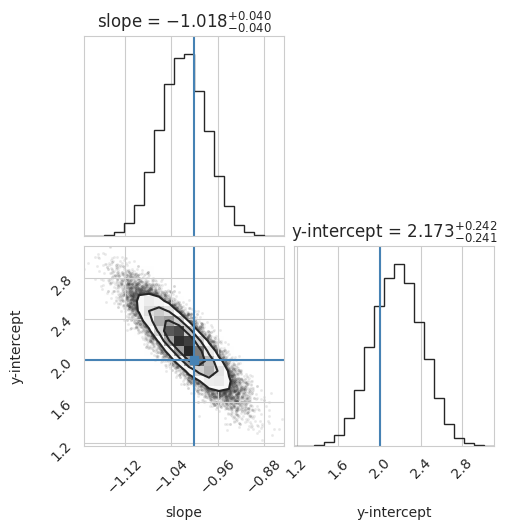

In [303]:
# HMC Corner plot
markers = get_samples(truth)
physical_samples = np.array(samples.numpy()).reshape(50,750,2)
corner(physical_samples, truths = markers, show_titles=True, title_fmt='.3f', labels = [r'slope', r'y-intercept']);